In [ ]:
#pip install --upgrade networkx
#pip install pennylane


City Labels: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}


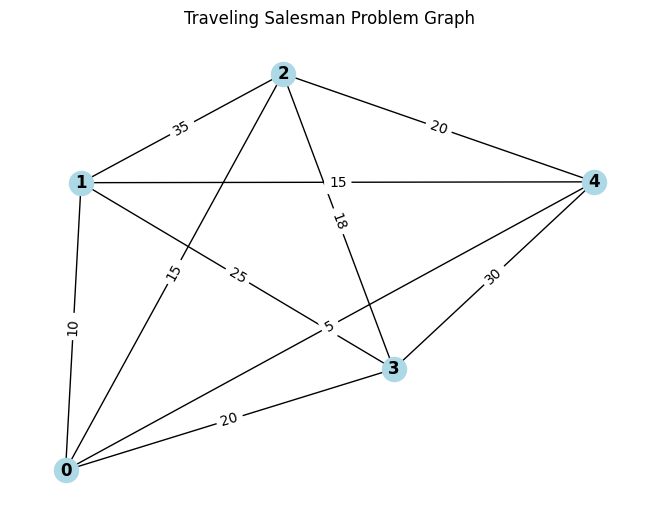

In [1]:
import pennylane
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa
import networkx as nx
import matplotlib.pyplot as plt
import time
import psutil

# Define the graph for the Traveling Salesman Problem (TSP)
# Each edge represents a path between two cities with an associated distance
distance_matrix = np.array([
    [0, 10, 15, 20, 5],
    [10, 0, 35, 25, 15],
    [15, 35, 0, 18, 20],
    [20, 25, 18, 0, 30],
    [5, 15, 20, 30, 0]
])

# Create the graph from the distance matrix

graph = nx.from_numpy_array(distance_matrix)

# Extract city labels (assuming they correspond to node indices)
city_labels = {i: str(i) for i in range(len(distance_matrix))}
print("City Labels:", city_labels)

# Draw the graph with edge labels for distances
pos = nx.spring_layout(graph)  # positions for all nodes
nx.draw(graph, pos, with_labels=True, node_color='lightblue', font_weight='bold')
labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
plt.title("Traveling Salesman Problem Graph")
plt.show()

# Start measuring time and memory
start_time = time.time()
process = psutil.Process()

# Define the number of qubits (cities) and the range of wires
num_nodes = graph.number_of_nodes()
wires = range(num_nodes)

# Define the cost and mixer Hamiltonians for the QAOA algorithm
cost_h, mixer_h = qaoa.maxcut(graph)

# Define the number of QAOA layers
num_qaoa_layers = 2  # Adjust this value as needed

In [2]:
## need work around on below code 

In [ ]:
# Define the QAOA layers
def qaoa_layer(gamma, alpha):
  qaoa.cost_layer(gamma, cost_h)
  qaoa.mixer_layer(alpha, mixer_h)
    
# Define the number of nodes (based on distance matrix dimensions)
num_nodes = len(distance_matrix)

# Assuming num_nodes is defined correctly
# Initialize parameters for all qubits
params = pennylane.init.randopt(2 * num_nodes)  # Initialize parameters for all qubits

def circuit(params):
    
    for w in range(num_nodes):
        # Apply single-qubit rotations using parameters (e.g., Ry, Rz)
        qml.RY(params[w * 2], wires=w)
        qml.RZ(params[w * 2 + 1], wires=w)

        # Add entangling gates between qubits (e.g., CNOT)
        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                qml.CNOT(wires=[i, j])

# Initialize the quantum device for simulation
dev = qml.device('default.qubit', wires=len(wires))

# Assuming your circuit uses the same number of qubits as nodes in the graph


wires = range(num_nodes)  # Create a list of qubits

# Option 1: Cost function with loop (assuming cost is sum of PauliY on all qubits)
@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    cost_op = qml.sum([qml.PauliY(w) for w in wires])
    return qml.expval(cost_op)

# Initialize the optimizer with a specific learning rate
learning_rate = 0.01
optimizer = qml.GradientDescentOptimizer(stepsize=learning_rate)
steps = 200
params = np.array([[0.5, 0.5] for _ in range(num_qaoa_layers)], requires_grad=True)

# Optimize the parameters to minimize the cost function (maximize total distance)
for i in range(steps):
  params = optimizer.step(cost_function, params)

print("Optimal Parameters:", params)

# Add measurement to get the probabilities of each bitstring
@qml.qnode(dev)
def probability_circuit(params):
  circuit(params)
  return qml.probs(wires=wires)

# Get the probabilities of each bitstring
probabilities = probability_circuit(params)

# Stop measuring time and memory
end_time = time.time()
memory_usage = process.memory_info().rss / 1024  # memory usage in KB

# Plot the quantum probabilities distribution for bitstrings
plt.bar(range(2 ** num_nodes), probabilities)
plt.title("Quantum Probabilities Distribution for Bitstrings")
plt.xlabel("Bitstring")
plt.ylabel("Probability")